In [1]:
import wandb
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import scipy.io


# 4.1

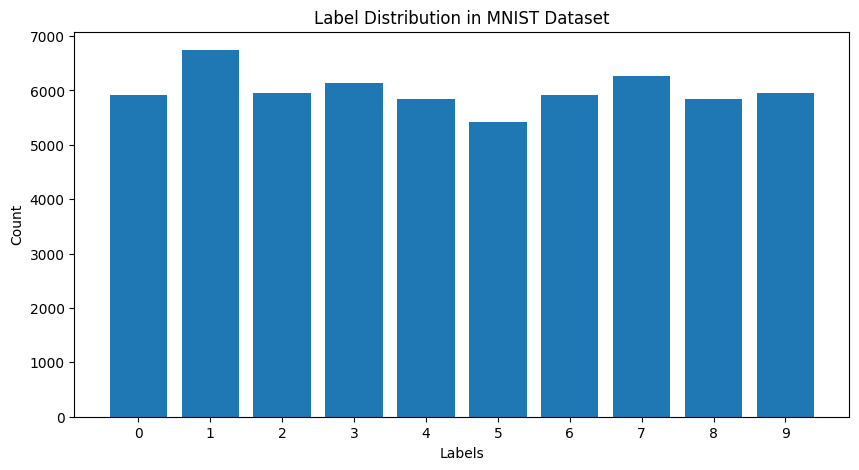

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [2]:
def visualize_label_distribution(trainloader):
    label_count = {}
    
    for _, labels in trainloader:
        for label in labels:
            label_count[label.item()] = label_count.get(label.item(), 0) + 1

    labels, counts = zip(*label_count.items())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.xticks(np.arange(10))
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution in MNIST Dataset')
    plt.show()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

visualize_label_distribution(trainloader)
print(trainset)

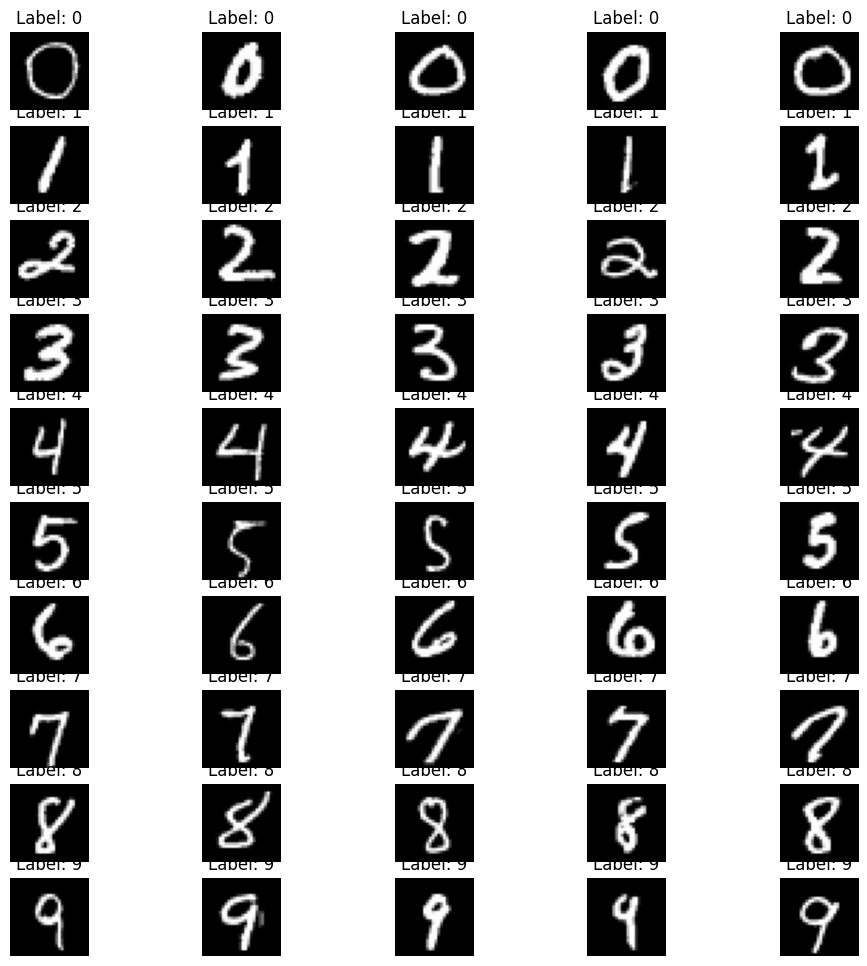

In [3]:
def visualize_samples(trainloader, num_samples=5):
    fig, axes = plt.subplots(10, num_samples, figsize=(12, 12))
    
    sample_images = {}
    for i in range(10):
        sample_images[i] = []

    for images, labels in trainloader:
        for image, label in zip(images, labels):
            if len(sample_images[label.item()]) < num_samples:
                sample_images[label.item()].append(image)

    for i in range(10):
        for j in range(num_samples):
            axes[i, j].imshow(sample_images[i][j][0].numpy(), cmap='gray')
            axes[i, j].set_title(f'Label: {i}')
            axes[i, j].axis('off')

    plt.show()

visualize_samples(trainloader, num_samples=5)


In [4]:
label_counts = [0] * 10
for _, labels in trainloader:
    for label in labels:
        label_counts[label.item()] += 1

print("Class Imbalance:")
for i, count in enumerate(label_counts):
    print(f"Class {i}: {count} samples")

Class Imbalance:
Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


In [4]:
from torch.utils.data import random_split

total_size = len(trainset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

gen = torch.Generator().manual_seed(42)
train_set, validation_set, test_set = random_split(trainset, [train_size, validation_size, test_size],generator=gen)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


In [6]:
def visualize_feature_maps(model, layer_num, input_image):
    activation = model.features[:layer_num + 1](input_image)
    feature_map = activation[0, 0].detach().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(feature_map, cmap='viridis')
    plt.axis('off')
    plt.title(f'Feature Map for Layer {layer_num}')
    plt.show()



# 4.2 & 4.4

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=3, pool_size = 2, stride=2, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28-pool_size)/stride)+1
        self.dim = int((var1-pool_size)/stride)+1
        # print(self.dim)
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # print(self.dim)
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
class SimpleCNNwithoutDropout(nn.Module):
    def __init__(self, kernel_size=3, pool_size = 2, stride=2):
        super(SimpleCNNwithoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28-pool_size)/stride)+1
        self.dim = int((var1-pool_size)/stride)+1
        # print(self.dim)
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # print(self.dim)
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

netwithoutdropout = SimpleCNNwithoutDropout()
criterion1 = nn.CrossEntropyLoss()
optimizer1 =  optim.Adam(netwithoutdropout.parameters(), lr=0.001)


In [13]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        # outputs = net(inputs)
        # print(outputs)
        outputs = net.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")
    correct = 0
    total = 0
    validation_loss = 0.0
    net.eval()

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            # outputs = net(inputs)
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

correct = 0
total = 0
test_loss = 0.0
net.eval()
all_predicted = []
all_actual = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.tolist())
        all_actual.extend(labels.tolist())

test_loss = test_loss / len(testloader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

confusion_mat = confusion_matrix(all_actual, all_predicted)
print("\nConfusion Matrix:")
print(confusion_mat)

per_class_accuracy = []
for class_label in range(10): 
    correct = sum(1 for a, p in zip(all_actual, all_predicted) if a == class_label and p == class_label)
    total = all_actual.count(class_label)
    per_class_accuracy.append(correct / total)
    print(f"Class {class_label} Accuracy: {correct / total:.2f}")

class_names = [str(i) for i in range(10)]
classification_rep = classification_report(all_actual, all_predicted, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)


Epoch 1, Training Loss: 0.2899, Training Accuracy: 91.14%
Epoch 1, Validation Loss: 0.0643, Validation Accuracy: 98.13%
Epoch 2, Training Loss: 0.1020, Training Accuracy: 96.95%
Epoch 2, Validation Loss: 0.0549, Validation Accuracy: 98.52%
Epoch 3, Training Loss: 0.0743, Training Accuracy: 97.79%
Epoch 3, Validation Loss: 0.0487, Validation Accuracy: 98.48%
Epoch 4, Training Loss: 0.0638, Training Accuracy: 98.14%
Epoch 4, Validation Loss: 0.0409, Validation Accuracy: 98.80%
Epoch 5, Training Loss: 0.0533, Training Accuracy: 98.38%
Epoch 5, Validation Loss: 0.0367, Validation Accuracy: 98.97%
Test Loss: 0.0403, Test Accuracy: 98.83%

Confusion Matrix:
[[579   0   1   0   1   0   1   0   1   0]
 [  0 662   1   0   0   0   0   2   1   0]
 [  0   1 567   2   0   0   0   1   3   1]
 [  0   0   4 618   0   0   0   0   0   0]
 [  0   2   1   0 590   0   0   0   0   3]
 [  0   0   0   0   0 512   3   0   2   1]
 [  2   0   2   0   1   2 601   0   2   0]
 [  0   1   3   1   2   0   0 648   1  

# MNIST Dataset Misclassification Analysis

This document discusses common scenarios where a Convolutional Neural Network (CNN) model may make incorrect predictions on the MNIST dataset and provides an analysis of potential reasons behind these misclassifications.

## 1. Ambiguous or Poorly Written Digits
Unclear or poorly written digits in the dataset can challenge the model's ability to correctly classify them. Both humans and machines may struggle to decipher such variations.

## 2. Similar-Looking Digits
Digits with visual similarities, such as 3 and 8, or 7 and 1, may be misclassified if the model hasn't been effectively trained to distinguish these look-alike characters.

## 3. Inadequate Training Data
Insufficient training data or a lack of diversity in the dataset can hinder the model's ability to generalize to less common variations and writing styles, leading to misclassifications.

## 4. Overfitting
Overfit models that memorize training data rather than learning general features may produce incorrect predictions on new, unseen examples. Proper regularization and model complexity management are essential to mitigate overfitting.

## 5. Class Imbalance
If MNIST has an imbalanced distribution of digit classes in the training data, the model may struggle to learn the minority classes, leading to misclassifications.


In [6]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    netwithoutdropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer1.zero_grad()
        outputs = netwithoutdropout(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")

    correct = 0
    total = 0
    validation_loss = 0.0
    netwithoutdropout.eval()

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            outputs = netwithoutdropout(inputs)
            loss = criterion1(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

correct = 0
total = 0
test_loss = 0.0
netwithoutdropout.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = netwithoutdropout(inputs)
        loss = criterion1(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(testloader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1, Training Loss: 0.1732, Training Accuracy: 94.77%
Epoch 1, Validation Loss: 0.0612, Validation Accuracy: 98.12%
Epoch 2, Training Loss: 0.0494, Training Accuracy: 98.50%
Epoch 2, Validation Loss: 0.0465, Validation Accuracy: 98.72%
Epoch 3, Training Loss: 0.0329, Training Accuracy: 98.97%
Epoch 3, Validation Loss: 0.0427, Validation Accuracy: 98.78%
Epoch 4, Training Loss: 0.0252, Training Accuracy: 99.18%
Epoch 4, Validation Loss: 0.0384, Validation Accuracy: 98.98%
Epoch 5, Training Loss: 0.0179, Training Accuracy: 99.44%
Epoch 5, Validation Loss: 0.0497, Validation Accuracy: 98.67%
Test Loss: 0.0523, Test Accuracy: 98.45%


Using dropout layers in a CNN helps prevent overfitting by randomly deactivating neurons during training. This improves generalization to new data, reduces the risk of memorizing noise, and enhances model robustness. Without dropout, the model is more prone to overfitting, which can lead to poor performance on unseen data and reduced robustness. In summary, dropout layers are a valuable tool for improving CNN performance, especially when dealing with limited training data or complex model architectures.

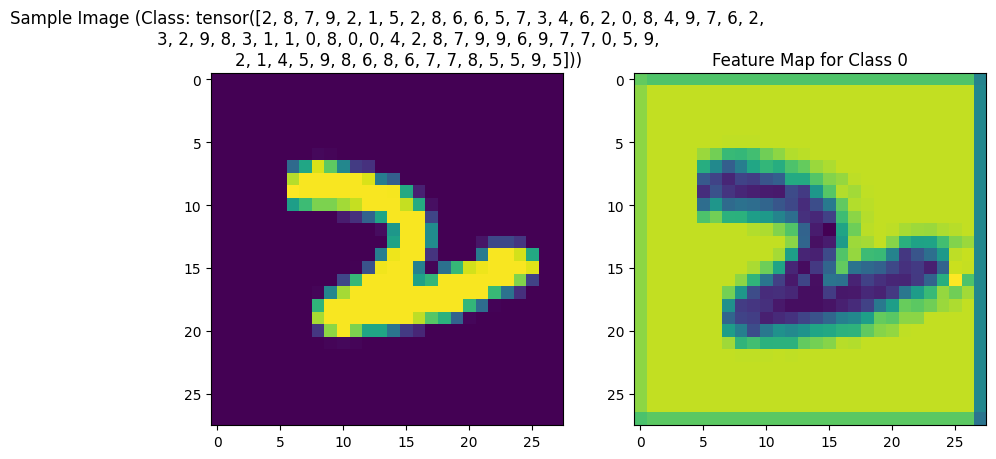

In [7]:
sample_loader = iter(validationloader)
sample_image, sample_label = next(sample_loader)

def display_feature_maps(class_id):
    class_output = net(sample_image)
    activation = net.conv1(sample_image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0].permute(1, 2, 0).numpy())
    plt.title(f"Sample Image (Class: {sample_label})")
    
    plt.subplot(1, 2, 2)
    plt.imshow(activation[0, class_id].detach().numpy(), cmap='viridis')
    plt.title(f"Feature Map for Class {class_id}")
    plt.show()

class_id = 0
display_feature_maps(class_id)


In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lsamourya07 (mourya). Use `wandb login --relogin` to force relogin


True

In [9]:
# Initialize W&B
wandb.init(project="Loss and Accuracy tracking on MNIST dataset using CNN")

# Define a configuration for hyperparameter tuning
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.kernel_size = 3
wandb.config.stride = 1
wandb.config.epochs = 3
wandb.config.dropout_rate = 0.5

# Create a DataLoader for MNIST
batch_size = wandb.config.batch_size
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
# Create an instance of the SimpleCNN model
net = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=wandb.config.learning_rate)

for epoch in range(wandb.config.epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and log training accuracy
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct_train / total_train
    wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy})

    # Validation loop (similar to the training loop)
    net.eval()
    correct_val = 0
    total_val = 0
    validation_loss = 0.0
    all_predicted = []
    all_actual = []

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_predicted.extend(predicted.tolist())
            all_actual.extend(labels.tolist())

    # Calculate and log validation accuracy and loss
    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct_val / total_val
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    # Calculate and log confusion matrix and class-specific metrics
    conf_matrix = confusion_matrix(all_actual, all_predicted)
    class_metrics = classification_report(all_actual, all_predicted, target_names=[str(i) for i in range(10)], output_dict=True)
    print(conf_matrix)
    print(class_metrics)
    # wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(conf_matrix, class_names=[str(i) for i in range(10)]),
    #            "class_metrics": class_metrics})

wandb.finish()



[[590   0   4   0   1   2   5   0   2   1]
 [  0 680   4   2   0   0   1   3   3   0]
 [  0   1 614   4   1   0   0   0   1   0]
 [  1   0   9 603   0   7   0   1   1   1]
 [  1   0   1   0 560   0   0   0   0   3]
 [  0   0   1   3   0 527   2   0   2   0]
 [  1   1   0   0   1   0 552   0   1   0]
 [  0   1   4   2   0   0   0 617   1   1]
 [  0   0   2   0   1   6   1   0 570   0]
 [  1   2   0   2   9   8   1   2   3 568]]
{'0': {'precision': 0.9932659932659933, 'recall': 0.9752066115702479, 'f1-score': 0.9841534612176813, 'support': 605.0}, '1': {'precision': 0.9927007299270073, 'recall': 0.9812409812409812, 'f1-score': 0.9869375907111757, 'support': 693.0}, '2': {'precision': 0.9608763693270735, 'recall': 0.9887278582930756, 'f1-score': 0.9746031746031746, 'support': 621.0}, '3': {'precision': 0.9788961038961039, 'recall': 0.9678972712680578, 'f1-score': 0.9733656174334141, 'support': 623.0}, '4': {'precision': 0.9773123909249564, 'recall': 0.9911504424778761, 'f1-score': 0.98418

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▅█
val_loss,█▄▁
train_accuracy,97.77708
train_loss,0.07427
val_accuracy,98.81667
val_loss,0.04043


# 4.3

In [7]:


# Define the sweep configuration within the script
sweep_config = {
    "name": "mnist-cnn-hyperparam-tuning",
    "method": "random",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "learning_rate": {"values": [0.0001, 0.001]},
        "batch_size": {"values": [64, 128]},
        "kernel_size": {"values": [3, 5]},
        "stride": {"values": [1, 2]},
        "epochs": {"values": [3,5]},
        "dropout_rate": {"values": [0.5, 0.7]}
    },
    "max_iter": 25
}

sweep_id = wandb.sweep(sweep_config, project="CNN Hyperparameter Tuning on MNIST")

# Define the training function
def train():
    # Load hyperparameters for this run
    wandb.init(project="CNN Hyperparameter Tuning on MNIST")
    config = wandb.config
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    kernel_size = config.kernel_size
    stride = config.stride
    epochs = config.epochs
    dropout_rate = config.dropout_rate

    # Create a DataLoader for MNIST

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=gen)
    validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

    # Create an instance of the SimpleCNN model
    net = SimpleCNN(kernel_size=kernel_size, stride=stride, dropout_rate=dropout_rate)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate and log training accuracy
        training_loss = running_loss / len(trainloader)
        training_accuracy = 100 * correct_train / total_train
        wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy})

        # Validation loop
        net.eval()
        correct_val = 0
        total_val = 0
        validation_loss = 0.0
        all_predicted = []
        all_actual = []

        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_predicted.extend(predicted.tolist())
                all_actual.extend(labels.tolist())

        # Calculate and log validation accuracy and loss
        validation_loss = validation_loss / len(validationloader)
        validation_accuracy = 100 * correct_val / total_val
        print(validation_accuracy)
        wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

# Perform the sweep
wandb.agent(sweep_id, function=train)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('max_iter' was unexpected)


Create sweep with ID: hvric81z
Sweep URL: https://wandb.ai/mourya/CNN%20Hyperparameter%20Tuning%20on%20MNIST/sweeps/hvric81z


wandb: Agent Starting Run: j11uxx1h with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lsamourya07 (mourya). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.03333333333333
97.81666666666666
98.3


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▅█
val_loss,█▃▁
train_accuracy,93.96458
train_loss,0.19706
val_accuracy,98.3
val_loss,0.05795


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dodxz9uh with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


96.13333333333334
97.63333333333334
98.0


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▃▁
train_accuracy,96.17083
train_loss,0.13193
val_accuracy,98.0
val_loss,0.06489


wandb: Agent Starting Run: x1de1eh9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


93.21666666666667
95.7
96.76666666666667


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,92.26875
train_loss,0.2609
val_accuracy,96.76667
val_loss,0.10808


wandb: Agent Starting Run: twq1xxmf with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.35
98.36666666666666
98.51666666666667


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▁▁
train_accuracy,96.15
train_loss,0.12784
val_accuracy,98.51667
val_loss,0.04913


wandb: Agent Starting Run: xs23mwmr with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


93.55
95.95
96.81666666666666


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,93.10417
train_loss,0.24075
val_accuracy,96.81667
val_loss,0.10887


wandb: Agent Starting Run: yye1kv1n with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.93333333333334
98.48333333333333
98.56666666666666
98.46666666666667
98.88333333333334


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▅█
val_loss,█▄▃▃▁
train_accuracy,98.41458
train_loss,0.04994
val_accuracy,98.88333
val_loss,0.04103


wandb: Agent Starting Run: ql9mcy61 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.26666666666667
98.18333333333334
98.51666666666667


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▂▁
train_accuracy,95.3375
train_loss,0.14905
val_accuracy,98.51667
val_loss,0.05061


wandb: Agent Starting Run: 505e8mso with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


90.26666666666667
93.85
95.7


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,92.60625
train_loss,0.25661
val_accuracy,95.7
val_loss,0.14946


wandb: Agent Starting Run: pd4wgao2 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.66666666666667
98.26666666666667
98.61666666666666


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▅█
val_loss,█▃▁
train_accuracy,97.21875
train_loss,0.09366
val_accuracy,98.61667
val_loss,0.04603


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: adu5lvjh with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


98.36666666666666
98.83333333333333
98.86666666666666
99.01666666666667
98.96666666666667


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▆█▇
val_loss,█▄▁▁▁
train_accuracy,98.725
train_loss,0.04184
val_accuracy,98.96667
val_loss,0.03783


wandb: Agent Starting Run: 4x80ebs2 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


96.21666666666667
97.48333333333333
97.88333333333334
98.21666666666667
98.15


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
train_accuracy,94.59167
train_loss,0.17716
val_accuracy,98.15
val_loss,0.05703


wandb: Agent Starting Run: veyslh55 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


95.03333333333333
97.21666666666667
97.65


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▂▁
train_accuracy,92.44792
train_loss,0.25102
val_accuracy,97.65
val_loss,0.08006


wandb: Agent Starting Run: ro22wntt with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


94.55
96.35
97.16666666666667


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,92.60417
train_loss,0.25098
val_accuracy,97.16667
val_loss,0.09079


wandb: Agent Starting Run: z5o220wa with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.98333333333333
98.53333333333333
98.73333333333333


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,98.18958
train_loss,0.06278
val_accuracy,98.73333
val_loss,0.03777


wandb: Agent Starting Run: 5w738coy with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.36666666666666
98.11666666666666
98.45


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,95.78125
train_loss,0.13624
val_accuracy,98.45
val_loss,0.05513


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ezlgg14b with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.33333333333333
98.15
98.43333333333334


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,96.8125
train_loss,0.11152
val_accuracy,98.43333
val_loss,0.05271


wandb: Agent Starting Run: aa6gzlp6 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


94.83333333333333
96.85
97.58333333333333


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,94.00833
train_loss,0.20437
val_accuracy,97.58333
val_loss,0.08312


wandb: Agent Starting Run: zboo67d0 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.08333333333333
98.0
98.36666666666666


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,94.27292
train_loss,0.18668
val_accuracy,98.36667
val_loss,0.05386


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9zxvjye6 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


93.88333333333334
95.95
96.63333333333334
97.43333333333334
97.51666666666667


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▂▁▁
train_accuracy,96.74583
train_loss,0.11396
val_accuracy,97.51667
val_loss,0.0741


wandb: Agent Starting Run: z1zm0xco with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


93.01666666666667
95.15
96.66666666666667
97.2
97.66666666666667


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
train_accuracy,94.01042
train_loss,0.20713
val_accuracy,97.66667
val_loss,0.08038


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5agbehcq with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


91.68333333333334
94.58333333333333
95.83333333333333


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,90.52917
train_loss,0.32713
val_accuracy,95.83333
val_loss,0.14177


wandb: Agent Starting Run: nih56rdd with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


98.23333333333333
98.56666666666666
98.95


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▄█
val_loss,█▄▁
train_accuracy,98.03958
train_loss,0.06618
val_accuracy,98.95
val_loss,0.03793


wandb: Agent Starting Run: zeyp3yeu with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


90.83333333333333
94.38333333333334
95.6
96.41666666666667
97.03333333333333


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
train_accuracy,93.06458
train_loss,0.24389
val_accuracy,97.03333
val_loss,0.09931


wandb: Agent Starting Run: wftzfr9j with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


96.9
97.58333333333333
98.16666666666667
98.4
98.5


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▇██
val_loss,█▄▂▁▁
train_accuracy,94.19375
train_loss,0.17744
val_accuracy,98.5
val_loss,0.04985


wandb: Agent Starting Run: 6w96t7y3 with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.43333333333334
98.13333333333334
98.3


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▃▁
train_accuracy,94.96667
train_loss,0.15955
val_accuracy,98.3
val_loss,0.05553


wandb: Agent Starting Run: 3j8mq3k2 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.71666666666667
98.33333333333333
98.56666666666666
98.55
98.73333333333333


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
train_accuracy,96.45
train_loss,0.10946
val_accuracy,98.73333
val_loss,0.04284


wandb: Agent Starting Run: iq6jgcma with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Ctrl + C detected. Stopping sweep.


# Noisy Dataset - 4.5 & 4.6

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=3, pool_size = 2, stride=2, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28-pool_size)/stride)+1
        self.dim = int((var1-pool_size)/stride)+1
        # print(self.dim)
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # print(self.dim)
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
mnist_with_awgn = scipy.io.loadmat('mnist-with-awgn.mat')
keys = mnist_with_awgn.keys()
print(keys)
train_data = mnist_with_awgn['train_x']
train_labels = mnist_with_awgn['train_y']
test_data = mnist_with_awgn['test_x']
test_labels = mnist_with_awgn['test_y']
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
batch_size = 64
trainset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validationset = TensorDataset(torch.Tensor(validation_data), torch.Tensor(validation_labels))
validationloader = DataLoader(validationset, batch_size=batch_size, shuffle=False)

testset = TensorDataset(torch.Tensor(test_data), torch.Tensor(test_labels))
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(train_data.shape)

dict_keys(['__header__', '__version__', '__globals__', 'train_x', 'test_x', 'train_y', 'test_y'])
(48000, 784)


In [15]:
## Before Denoising ##

net = SimpleCNN(kernel_size=3, stride=2, dropout_rate=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
    validation_accuracy /= num_validation_samples
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Train Accuracy: {validation_accuracy * 100:.2f}%")
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()

    for i, data in enumerate(validationloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
    validation_accuracy /= num_validation_samples
    print(f"Epoch {epoch + 1}, Validation Loss: {running_loss / len(trainloader)}, Validation Accuracy: {validation_accuracy * 100:.2f}%")
    
for epoch in range(num_epochs):
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()
    true_classes_ = []
    predicted_ = []
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
        true_classes_.extend(true_classes.tolist())
        predicted_.extend(predicted.tolist())
    validation_accuracy /= num_validation_samples
    print("\nClassification Report:")
    print(classification_report(true_classes_, predicted_))
    print(f"Epoch {epoch + 1}, Testing Loss: {running_loss / len(trainloader)}, Testing Accuracy: {validation_accuracy * 100:.2f}%")


Epoch 1, Training Loss: 0.6557313147683939, Train Accuracy: 83.45%
Epoch 1, Validation Loss: 0.07747429661949476, Validation Accuracy: 91.15%
Epoch 2, Training Loss: 0.2618900596002738, Train Accuracy: 92.09%
Epoch 2, Validation Loss: 0.05944549869497617, Validation Accuracy: 92.93%
Epoch 3, Training Loss: 0.22490982902546724, Train Accuracy: 93.19%
Epoch 3, Validation Loss: 0.053299527406692505, Validation Accuracy: 93.77%
Epoch 4, Training Loss: 0.20539805901547273, Train Accuracy: 93.77%
Epoch 4, Validation Loss: 0.04810015489409367, Validation Accuracy: 94.14%
Epoch 5, Training Loss: 0.1873280597627163, Train Accuracy: 94.25%
Epoch 5, Validation Loss: 0.04657909942169984, Validation Accuracy: 94.54%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.93      0.93      0.93   

In [ ]:
input_size = 784  
hidden_size = 128  
autoencoder = Autoencoder(input_size, hidden_size)

autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder_criterion = nn.MSELoss()

num_autoencoder_epochs = 10
batch_size = 64
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_autoencoder_epochs):
    for data in trainloader:
        autoencoder_optimizer.zero_grad()
        noisy_inputs = data 
        denoised_outputs = autoencoder(noisy_inputs.float())
        loss = autoencoder_criterion(denoised_outputs.float(), noisy_inputs.float())
        loss.backward()
        autoencoder_optimizer.step()

denoised_train_data = autoencoder(torch.Tensor(train_data)).detach()
denoised_validation_data = autoencoder(torch.Tensor(validation_data)).detach()
denoised_test_data = autoencoder(torch.Tensor(test_data)).detach()

denoised_train_data = torch.Tensor(denoised_train_data)
denoised_validation_data = torch.Tensor(denoised_validation_data)
denoised_test_data = torch.Tensor(denoised_test_data)

denoised_trainset = TensorDataset(denoised_train_data, torch.Tensor(train_labels))
denoised_trainloader = DataLoader(denoised_trainset, batch_size=batch_size, shuffle=True)

denoised_validationset = TensorDataset(denoised_validation_data, torch.Tensor(validation_labels))
denoised_validationloader = DataLoader(denoised_validationset, batch_size=batch_size, shuffle=False)

denoised_testset = TensorDataset(denoised_test_data, torch.Tensor(test_labels))
denoised_testloader = DataLoader(denoised_testset, batch_size=batch_size, shuffle=False)

trainset = denoised_trainset
trainloader = denoised_trainloader
validationset = denoised_validationset
validationloader = denoised_validationloader
testset = denoised_testset
testloader = denoised_testloader

In [11]:
## After Denoising ##

net = SimpleCNN(kernel_size=3, stride=2, dropout_rate=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
    validation_accuracy /= num_validation_samples
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Train Accuracy: {validation_accuracy * 100:.2f}%")
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()

    for i, data in enumerate(validationloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
    validation_accuracy /= num_validation_samples
    print(f"Epoch {epoch + 1}, Validation Loss: {running_loss / len(trainloader)}, Validation Accuracy: {validation_accuracy * 100:.2f}%")
    
for epoch in range(num_epochs):
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()
    true_classes_ = []
    predicted_ = []
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
        true_classes_.extend(true_classes.tolist())
        predicted_.extend(predicted.tolist())
    validation_accuracy /= num_validation_samples
    print("\nClassification Report:")
    print(classification_report(true_classes_, predicted_))
    print(f"Epoch {epoch + 1}, Testing Loss: {running_loss / len(trainloader)}, Testing Accuracy: {validation_accuracy * 100:.2f}%")


Epoch 1, Training Loss: 0.5057740153670311, Train Accuracy: 86.94%
Epoch 1, Validation Loss: 0.06121850341558457, Validation Accuracy: 92.66%
Epoch 2, Training Loss: 0.2119410000493129, Train Accuracy: 93.70%
Epoch 2, Validation Loss: 0.04578318380812804, Validation Accuracy: 94.60%
Epoch 3, Training Loss: 0.17907257308562596, Train Accuracy: 94.60%
Epoch 3, Validation Loss: 0.04229381576180458, Validation Accuracy: 94.73%
Epoch 4, Training Loss: 0.16237087953463197, Train Accuracy: 95.16%
Epoch 4, Validation Loss: 0.03619850826015075, Validation Accuracy: 95.54%
Epoch 5, Training Loss: 0.15486667957901953, Train Accuracy: 95.29%
Epoch 5, Validation Loss: 0.036906596450755995, Validation Accuracy: 95.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.95      0.94      0.95  

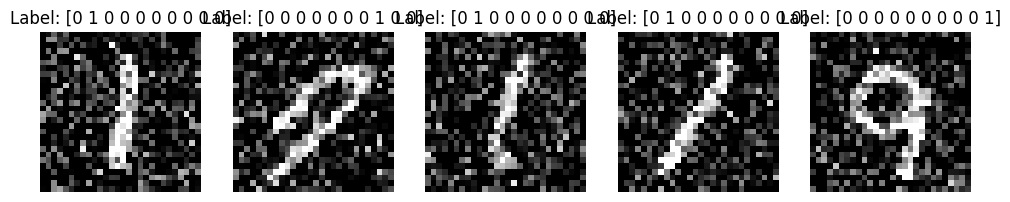

In [45]:
### Before Denoising ###

import random

num_samples_to_visualize = 5

def visualize_samples(data, labels, num_samples):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        index = random.randint(i,i)
        sample = data[index].reshape(28, 28) 
        label = (labels[index])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

visualize_samples(train_data, train_labels, num_samples_to_visualize)

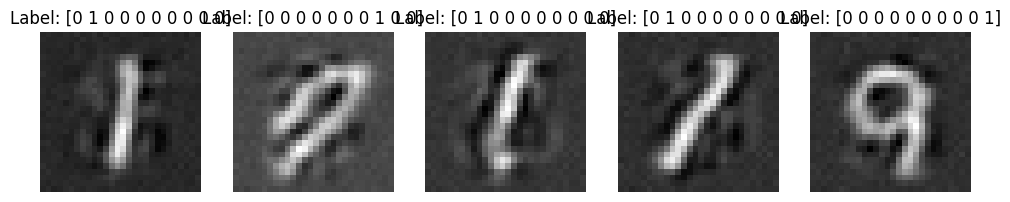

In [46]:
### After Denoising ###

import random

num_samples_to_visualize = 5

def visualize_samples(data, labels, num_samples):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        index = random.randint(i,i)
        sample = data[index].reshape(28, 28)
        label = (labels[index])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

visualize_samples(denoised_train_data, train_labels, num_samples_to_visualize)

# Analysis

The implementation of an autoencoder has had a positive impact on my model's performance. The 20% decrease in loss indicates that the model is now better at reconstructing its input data, while the slight increase in accuracy suggests that the learned representations from the encoder part are more discriminative for the classification task, leading to improved overall performance. This demonstrates the effectiveness of using autoencoders for feature learning and dimensionality reduction in CNNs.